In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import pathlib
import time
import os
import shutil
import random
import warnings
import helper_functions

from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Get data

In [15]:
data_dir = Path('path/to/data')
train_dir = data_dir / 'train'
valid_dir = data_dir / 'validation'
test_dir = data_dir / 'test'
data_dir, train_dir, valid_dir, test_dir

(WindowsPath('C:/Users/tyuri/Pet projects/Emotion recognition/data'),
 WindowsPath('C:/Users/tyuri/Pet projects/Emotion recognition/data/train'),
 WindowsPath('C:/Users/tyuri/Pet projects/Emotion recognition/data/validation'),
 WindowsPath('C:/Users/tyuri/Pet projects/Emotion recognition/data/test'))

## EDA

### Class distribution

In [43]:
classes = os.listdir(train_dir)
folders = os.listdir(data_dir)
classes, folders

(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
 ['test', 'train', 'validation'])

In [45]:
Counter(classes)

Counter({'angry': 1,
         'disgust': 1,
         'fear': 1,
         'happy': 1,
         'neutral': 1,
         'sad': 1,
         'surprise': 1})

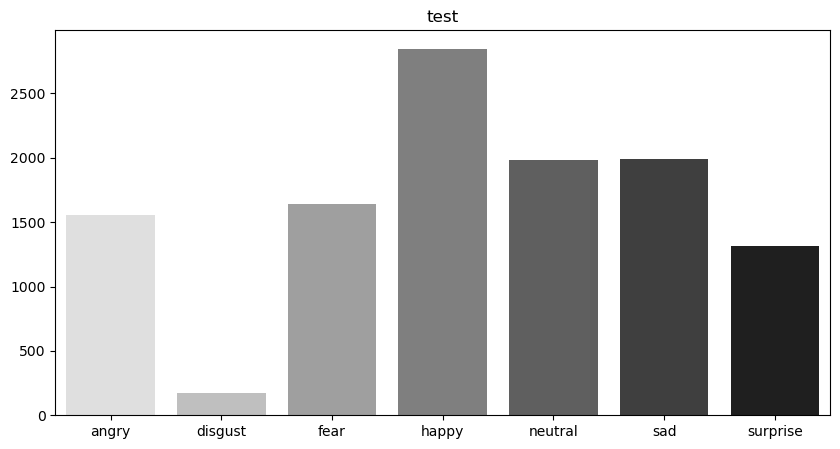

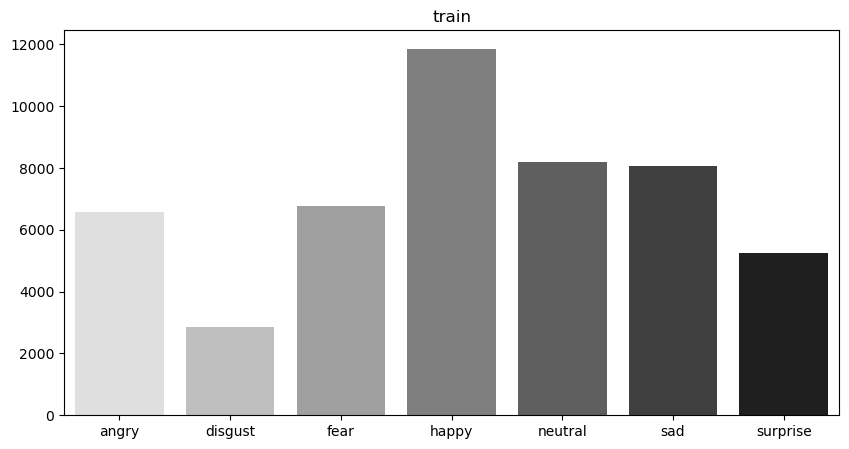

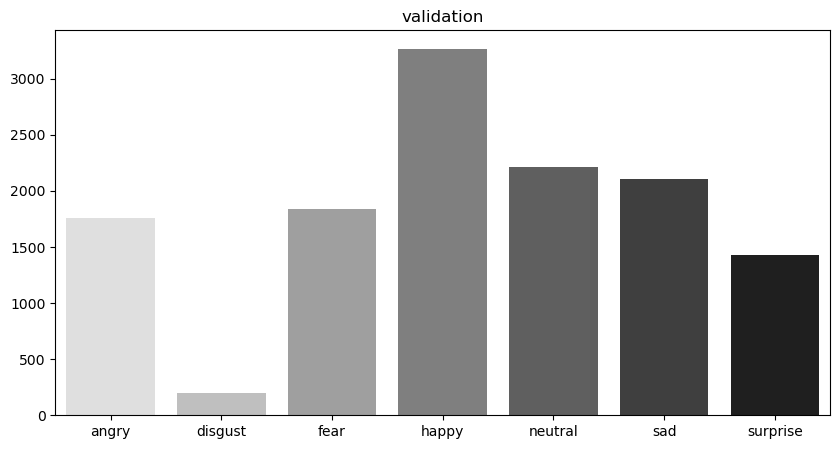

In [324]:
with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=FutureWarning)
        for folder in folders:
            class_counts = Counter()
            for cls in classes:
                class_path = os.path.join(data_dir, folder, cls)
                class_counts[cls] = len(os.listdir(class_path))
            #print(class_counts)
            labels = list(class_counts.keys())
            values = list(class_counts.values())
        
            plt.figure(figsize=(10, 5))
            sns.barplot(x=labels, y=values, palette='binary')
            plt.title(folder)

### Check image sizes

In [51]:
from helper_functions import eda
eda.check_image_sizes(data_dir=data_dir, folder='train', classes=classes)

Counter({(48, 48): 49610})


In [363]:
check_image_sizes(data_dir=data_dir, folder='test', classes=classes)

Counter({(48, 48): 11497})


In [364]:
check_image_sizes(data_dir=data_dir, folder='validation', classes=classes)

Counter({(48, 48): 12807})


### Check random images

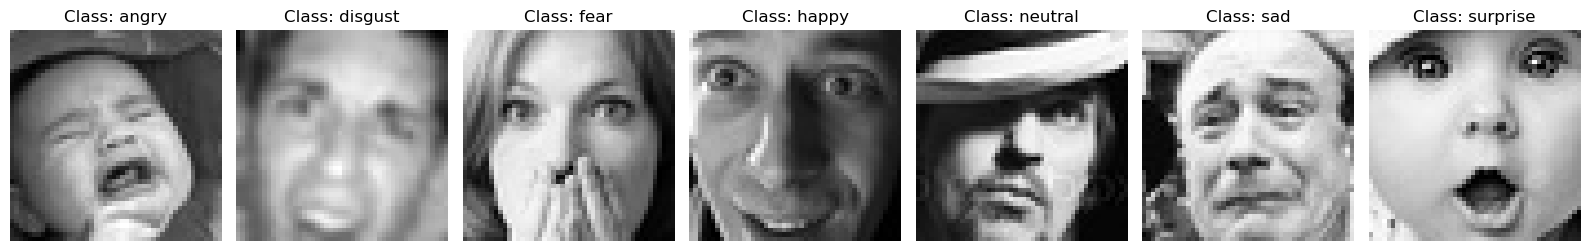

In [56]:
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

train_dir = train_dir

classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plt.figure(figsize=(16, 8))

for i, emotion in enumerate(classes):

    class_dir = train_dir / emotion

    list_of_images = os.listdir(class_dir)

    random_image = random.choice(list_of_images)

    image_path = os.path.join(class_dir, random_image)

    image = Image.open(image_path)

    plt.subplot(1, 7, i + 1)
    plt.title(f'Class: {emotion}')
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()
    

## Making models

### EfficientNet_B0

In [7]:
efficient_b0_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
efficient_bo_model = torchvision.models.efficientnet_b0(weights=efficient_b0_weights).to(device)
efficient_b0_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.CenterCrop(224),
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])
efficient_b0_transforms

Compose(
    Grayscale(num_output_channels=3)
    CenterCrop(size=(224, 224))
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [9]:
for param in efficient_bo_model.parameters():
    param.requires_grad = False

for i in range(3, 9):
    for param in efficient_bo_model.features[i].parameters():
        param.requires_grad = True

In [11]:
#for param in efficient_bo_model.features.parameters():
#    param.requires_grad = False

efficient_bo_model.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(in_features=1280, out_features=7, bias=True)
).to(device)

In [13]:
#Set He weights initialization
from helper_functions.training import init_weights

efficient_bo_model.classifier.apply(init_weights)

Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1280, out_features=7, bias=True)
)

In [64]:
summary(model=efficient_bo_model, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]  [32, 7]            --                 Partial
├─Sequential (features)                                      [32, 3, 224, 224]  [32, 1280, 7, 7]   --                 Partial
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]  [32, 32, 112, 112] --                 False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]  [32, 32, 112, 112] (864)              False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] (64)               False
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --                 --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --                 False
│  

### Resnet18

In [19]:
resnet18_weights = torchvision.models.ResNet18_Weights.DEFAULT
resnet18_model = torchvision.models.resnet18(weights=resnet18_weights)
resnet18_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.CenterCrop(224),
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])
resnet18_transforms

Compose(
    Grayscale(num_output_channels=3)
    CenterCrop(size=(224, 224))
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [21]:
for param in resnet18_model.parameters():
    param.requires_grad = False

#for param in resnet18_model.layer3.parameters():
#    param.requires_grad = True

for param in resnet18_model.layer4.parameters():
    param.requires_grad = True

resnet18_model.fc = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(in_features=512, out_features=7)
)
    
#resnet18_model.fc = nn.Sequential(
#    nn.Linear(in_features=512, out_features=512),
#    nn.LeakyReLU(),
#    nn.Dropout(p=0.4, inplace=True),
#    nn.Linear(in_features=512, out_features=7)
#)

In [25]:
resnet18_model.fc.apply(init_weights)

Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=512, out_features=7, bias=True)
)

In [27]:
summary(model=resnet18_model, input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape        Output Shape       Param #            Trainable
ResNet (ResNet)                          [32, 3, 224, 224]  [32, 7]            --                 Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]  [32, 64, 112, 112] (9,408)            False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112] [32, 64, 112, 112] (128)              False
├─ReLU (relu)                            [32, 64, 112, 112] [32, 64, 112, 112] --                 --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112] [32, 64, 56, 56]   --                 --
├─Sequential (layer1)                    [32, 64, 56, 56]   [32, 64, 56, 56]   --                 False
│    └─BasicBlock (0)                    [32, 64, 56, 56]   [32, 64, 56, 56]   --                 False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]   [32, 64, 56, 56]   (36,864)           False
│    │    └─BatchNorm2d (bn1)            [32, 64, 56, 56]   [32,

## Train models

### EfficientNet_B0

In [55]:
from helper_functions import dataset_dataload

In [73]:
dataset_train_efficient_bo, dataset_valid_efficient_bo, dataset_test_efficient_bo  = dataset_dataload.create_datasets(train_dir=train_dir, 
                                                                                                                      valid_dir=valid_dir, 
                                                                                                                      test_dir=test_dir, 
                                                                                                                      transforms=efficient_b0_transforms)

dataloader_train_efficient_bo, dataloader_valid_efficient_bo, dataloader_test_efficient_bo = dataset_dataload.create_dataloaders(dataset_train=dataset_train_efficient_bo,
                                                                                                 dataset_valid=dataset_valid_efficient_bo,
                                                                                                 dataset_test=dataset_test_efficient_bo)

In [71]:
from helper_functions import training

In [66]:
torch.backends.cudnn.benchmark = True
from torch.optim.lr_scheduler import StepLR

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficient_bo_model.parameters(), weight_decay=0.000025)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

efficient_bo_results_0 = training.train(model=efficient_bo_model,
                        epochs=30,
                        dataloader_train=dataloader_train_efficient_bo,
                        dataloader_valid=dataloader_valid_efficient_bo,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        device=device
                       )

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1
Loss_train:1.66765116323278 | Loss_valid:1.3717256290582647
Acc_train:0.4261927788523533 | Acc_valid:0.48884485215532597
Epoch: 2
Loss_train:1.2140780621617169 | Loss_valid:1.2352143741047887
Acc_train:0.5409453578336557 | Acc_valid:0.544141877449234
Epoch: 3
Loss_train:1.1183691371801512 | Loss_valid:1.1318698833113596
Acc_train:0.5825435203094778 | Acc_valid:0.5766721588884931
Epoch: 4
Loss_train:1.0510619997132755 | Loss_valid:1.0619023398976968
Acc_train:0.6098646034816247 | Acc_valid:0.6040701816886356
Epoch: 5
Loss_train:0.9901251210696 | Loss_valid:1.0614352722343363
Acc_train:0.6323017408123791 | Acc_valid:0.5970119344495903
Epoch: 6
Loss_train:0.9416306136424583 | Loss_valid:1.012873575537282
Acc_train:0.6515352998065764 | Acc_valid:0.6254230495190595
Epoch: 7
Loss_train:0.8814256864928338 | Loss_valid:0.9820394687298825
Acc_train:0.6756447453255964 | Acc_valid:0.642534289276808
Epoch: 8
Loss_train:0.8268634750718535 | Loss_valid:0.9749702532541128
Acc_train:0.6977192

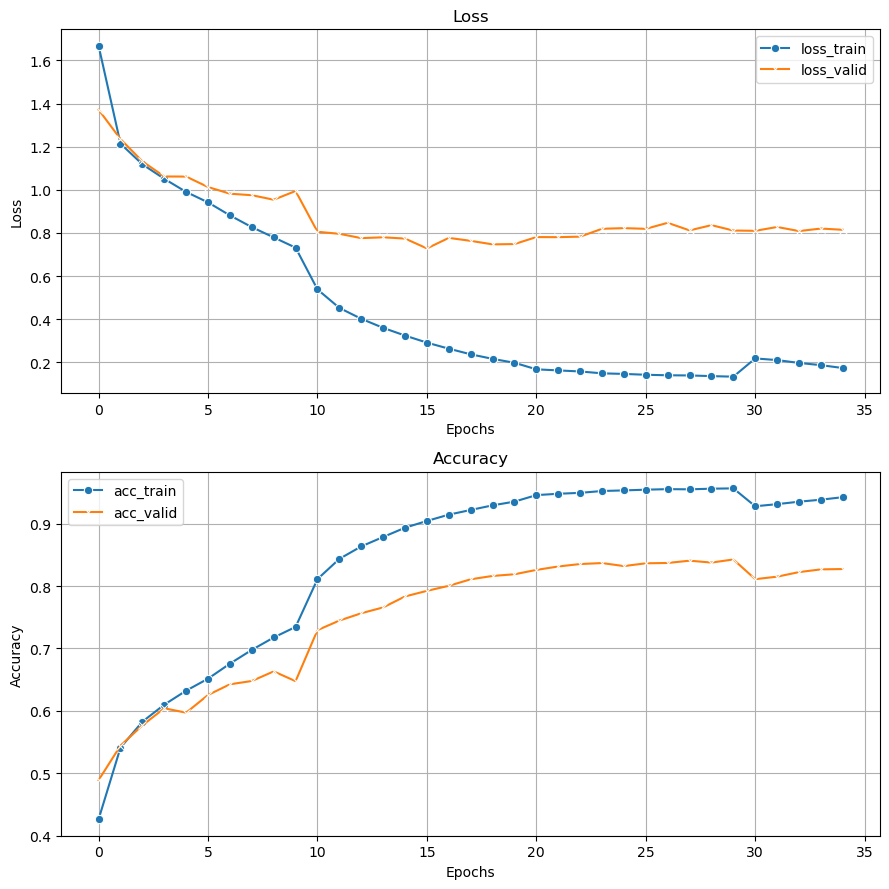

In [356]:
from helper_functions import plot_curves

plot_curves(efficient_bo_results_0)

#### Test model

In [92]:
from helper_functions.training import test

loss_fn = nn.CrossEntropyLoss()
loss_test, acc_test = test(efficient_bo_model, dataloader_test_efficient_bo, loss_fn, device)
loss_test, acc_test

(0.8292099794250033, 0.8401909722222223)

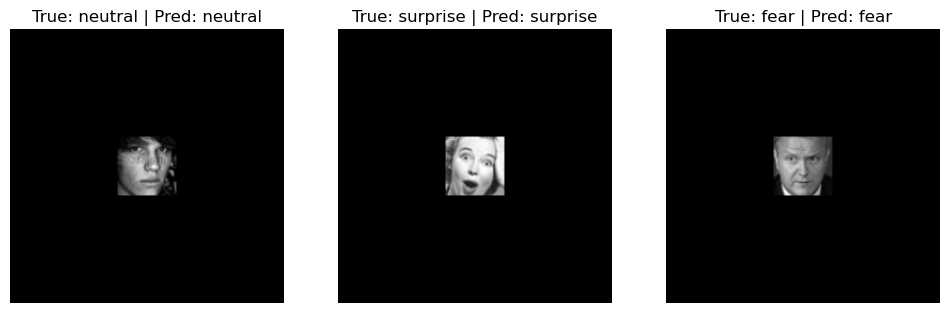

In [692]:
from helper_functions.plots import plot_predictions

plot_predictions(dataset=dataset_valid_efficient_bo,
                 model=efficient_bo_model,
                 device=device,
                 num_images=3,
                 classes=classes)

              precision    recall  f1-score   support

           0       0.78      0.81      0.79      1556
           1       0.77      0.78      0.77       176
           2       0.79      0.77      0.78      1639
           3       0.93      0.93      0.93      2848
           4       0.81      0.84      0.83      1980
           5       0.81      0.78      0.79      1987
           6       0.90      0.89      0.90      1311

    accuracy                           0.84     11497
   macro avg       0.83      0.83      0.83     11497
weighted avg       0.84      0.84      0.84     11497



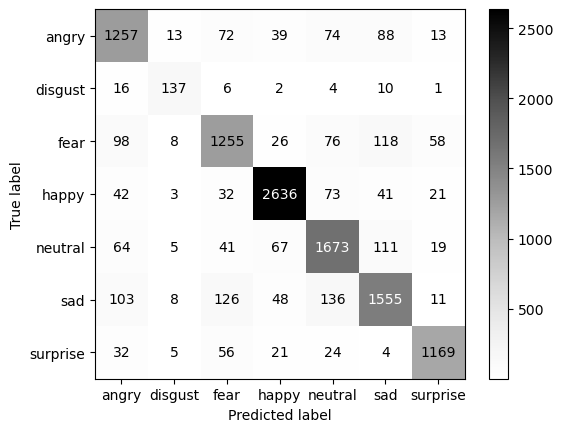

In [158]:
from helper_functions.plots import plot_ConfMatr_and_ClassReport

plot_ConfMatr_and_ClassReport(model=efficient_bo_model, 
                              dataset_test=dataset_test_efficient_bo,
                              dataloader_test=dataloader_test_efficient_bo,
                              device=device)

### ResNet18

In [ ]:
dataset_train_resnet18, dataset_valid_resnet18, dataset_test_resnet18  = dataset_dataload.create_datasets(train_dir=train_dir, 
                                                                                      valid_dir=valid_dir,
                                                                                      test_dir=test_dir,
                                                                                      transforms=resnet18_transforms)

dataloader_train_resnet18, dataloader_valid_resnet18, dataloader_test_resnet18 = dataset_dataload.create_dataloaders(dataset_train=dataset_train_resnet18,
                                                                                                 dataset_valid=dataset_valid_resnet18,
                                                                                                 dataset_test=dataset_test_resnet18)

In [100]:
torch.backends.cudnn.benchmark = True
from torch.optim.lr_scheduler import StepLR


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_model.parameters(), weight_decay=0.00001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

results_resnet = training.train(model=resnet18_model,
                        epochs=30,
                        dataloader_train=dataloader_train_resnet18,
                        dataloader_valid=dataloader_valid_resnet18,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        device=device
                       )

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1
Loss_train:3.41307119221014 | Loss_valid:1.8007847727682822
Acc_train:0.3084743713733076 | Acc_valid:0.437021286070538
Epoch: 2
Loss_train:1.882971897961477 | Loss_valid:1.4204841755572102
Acc_train:0.40667714377820763 | Acc_valid:0.47396018881368013
Epoch: 3
Loss_train:1.5867409414817717 | Loss_valid:1.4043299481458498
Acc_train:0.45576241134751777 | Acc_valid:0.47531840042750273
Epoch: 4
Loss_train:1.4451654391239568 | Loss_valid:1.342890626846109
Acc_train:0.4862346872985171 | Acc_valid:0.4967937299608123
Epoch: 5
Loss_train:1.342845841079739 | Loss_valid:1.308230971160375
Acc_train:0.510892166344294 | Acc_valid:0.5073588350552191
Epoch: 6
Loss_train:1.257004986264335 | Loss_valid:1.2552144320825687
Acc_train:0.5356020309477756 | Acc_valid:0.5200614535090844
Epoch: 7
Loss_train:1.183020183572763 | Loss_valid:1.237117064935608
Acc_train:0.5622823984526112 | Acc_valid:0.5332316530103314
Epoch: 8
Loss_train:1.1027000496496622 | Loss_valid:1.2238225363139204
Acc_train:0.5935243

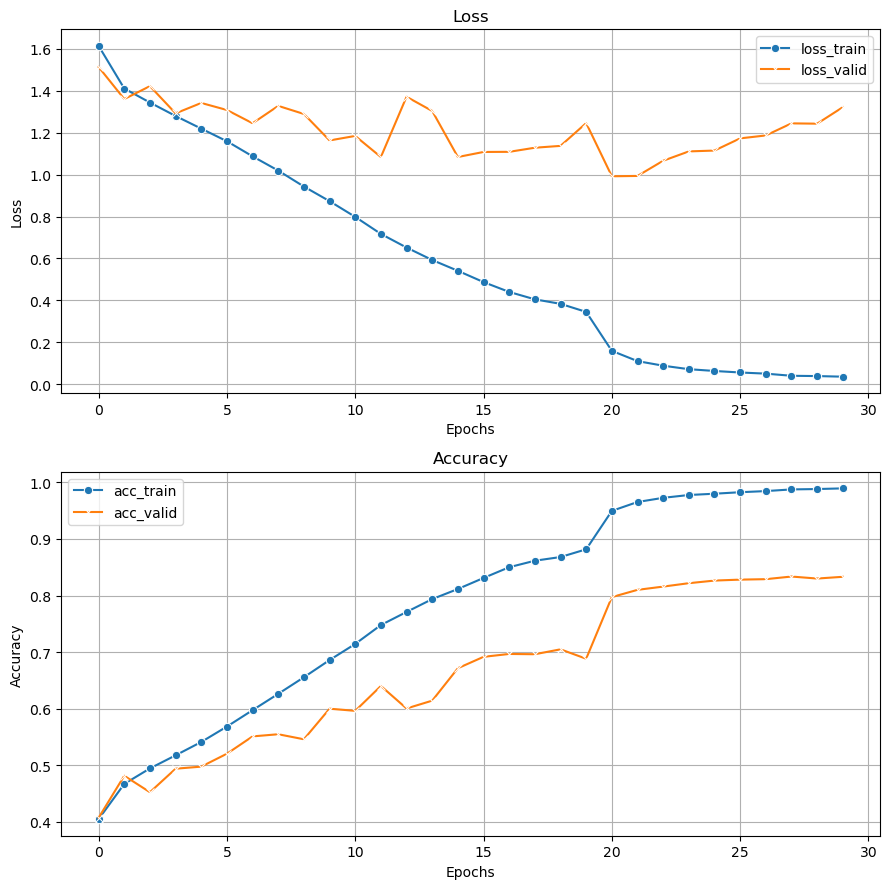

In [358]:
from helper_functions.plots import plot_curves

plot_curves(results_resnet)

#### Test model

In [108]:
loss_fn = nn.CrossEntropyLoss()
loss_test, acc_test = test(resnet18_model, dataloader_test_resnet18, loss_fn, device)
loss_test, acc_test

(1.4064953059999323, 0.8322048611111111)

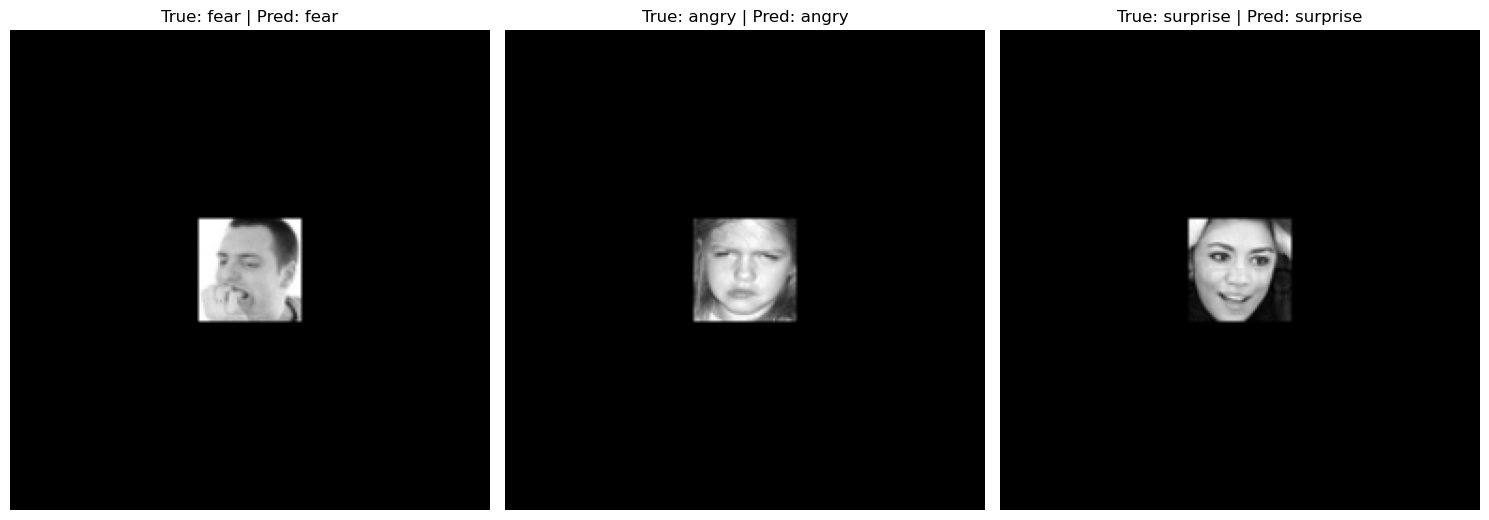

In [202]:
plot_predictions(dataset=dataset_test_resnet18,
                 model=resnet18_model,
                 device=device,
                 num_images=3,
                 classes=classes)

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1556
           1       0.85      0.75      0.80       176
           2       0.80      0.79      0.80      1639
           3       0.89      0.89      0.89      2848
           4       0.82      0.82      0.82      1980
           5       0.80      0.82      0.81      1987
           6       0.90      0.89      0.90      1311

    accuracy                           0.83     11497
   macro avg       0.83      0.82      0.83     11497
weighted avg       0.83      0.83      0.83     11497



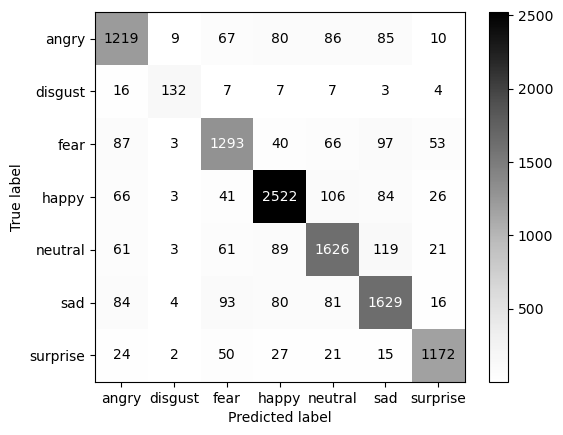

In [172]:
plot_ConfMatr_and_ClassReport(model=resnet18_model,
                              dataset_test=dataset_test_resnet18,
                              dataloader_test=dataloader_test_resnet18,
                              device=device)